Visualisation of the 4 macroeconomic regimes according to GDP and Inflation

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [ ]:

df = pd.read_csv("/content/gdp inflation raw.csv")


df["Date_dt"] = pd.to_datetime(df["Dates"], format="%b-%y") + pd.offsets.QuarterEnd(0)

# Compute Year-over-Year (YoY) growth
df["GDP_YoY"] = df["GDP"].pct_change(4) * 100
df["Inflation_YoY"] = df["Inflation"].pct_change(4) * 100

# Drop first 4 quarters with NaN
df = df.dropna().reset_index(drop=True)

In [ ]:
gdp_cycle, gdp_trend = sm.tsa.filters.hpfilter(df["GDP_YoY"], lamb=1600)
infl_cycle, infl_trend = sm.tsa.filters.hpfilter(df["Inflation_YoY"], lamb=1600)

df["gdp_trend"] = gdp_trend
df["gdp_cycle"] = gdp_cycle
df["infl_trend"] = infl_trend
df["infl_cycle"] = infl_cycle

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


In [ ]:
def classify_hp_cycle(gdp_cycle, infl_cycle):
    """
    Classify economic regime based on HP-filtered cycles.
    Positive GDP cycle => above trend
    Negative GDP cycle => below trend
    Positive inflation cycle => above trend
    Negative inflation cycle => below trend
    """
    if gdp_cycle > 0 and infl_cycle < 0:
        return "Goldilocks"
    elif gdp_cycle > 0 and infl_cycle > 0:
        return "Overheating"
    elif gdp_cycle < 0 and infl_cycle > 0:
        return "Stagflation"
    else:  # gdp_cycle < 0 and infl_cycle < 0
        return "Slowdown"

# Apply classification
df["Regime_hp"] = [classify_hp_cycle(g, i) for g, i in zip(df["gdp_cycle"], df["infl_cycle"])]


In [ ]:
def classify_threshold(gdp, infl):
    if gdp > 6 and infl < 4:
        return "Goldilocks"
    elif gdp > 6 and infl >= 4:
        return "Overheating"
    elif gdp <= 6 and infl >= 4:
        return "Stagflation"
    else:
        return "Slowdown"

df["Regime_thresh"] = [classify_threshold(g, i) for g, i in zip(df["GDP_YoY"], df["Inflation_YoY"])]

In [ ]:
df[['Dates', 'Regime_thresh']]

,Dates,Regime_thresh
0,Jun-12,Stagflation
1,Sep-12,Stagflation
2,Dec-12,Stagflation
3,Mar-13,Stagflation
4,Jun-13,Overheating
5,Sep-13,Stagflation
6,Dec-13,Overheating
7,Mar-14,Overheating
8,Jun-14,Overheating
9,Sep-14,Overheating


Scatter plot of the 4 regimes

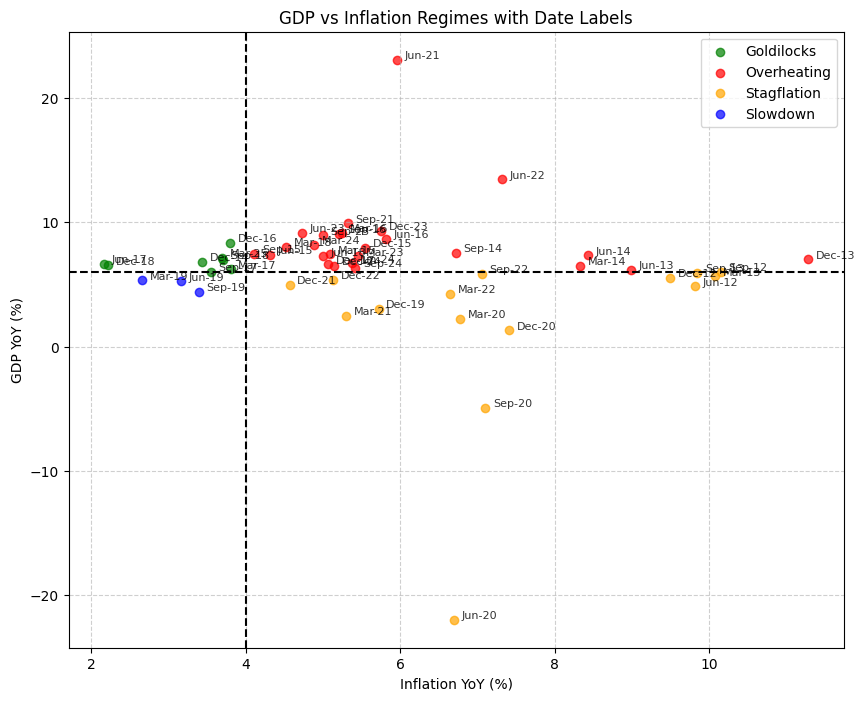

In [ ]:
plt.figure(figsize=(10,8))

for regime, color in zip(["Goldilocks","Overheating","Stagflation","Slowdown"],
                         ["green","red","orange","blue"]):
    subset = df[df["Regime_thresh"] == regime]
    plt.scatter(subset["Inflation_YoY"], subset["GDP_YoY"], label=regime, alpha=0.7, c=color)

    # Add date labels
    for _, row in subset.iterrows():
        plt.text(row['Inflation_YoY'] + 0.1, row['GDP_YoY'] + 0.1,
                 row['Dates'], fontsize=8, alpha=0.8)

plt.axhline(6, color="black", linestyle="--")   # GDP threshold
plt.axvline(4, color="black", linestyle="--")   # Inflation threshold
plt.xlabel("Inflation YoY (%)")
plt.ylabel("GDP YoY (%)")
plt.title("GDP vs Inflation Regimes with Date Labels")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


Line chart with the backgrouds as thresholds

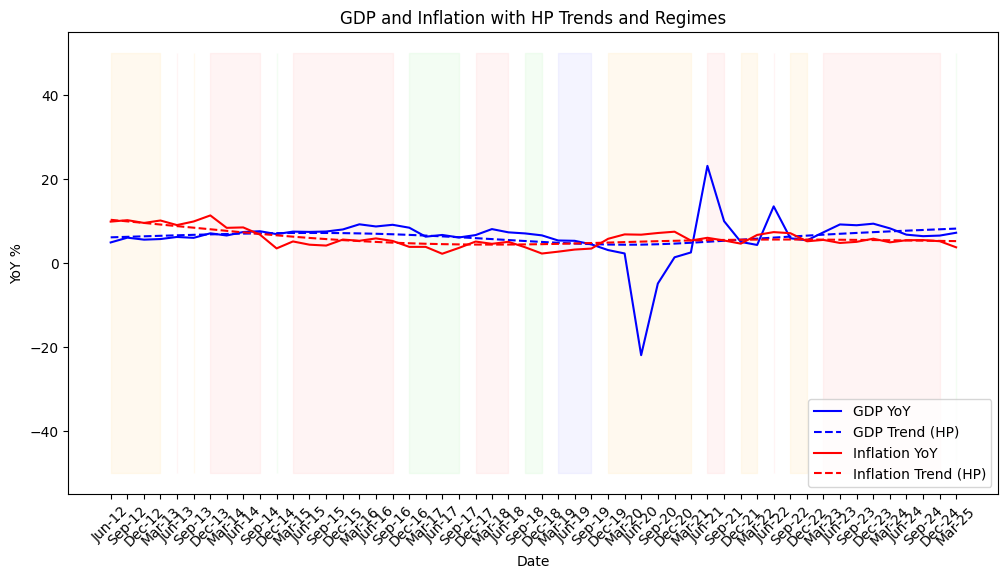

In [ ]:
plt.figure(figsize=(12,6))

# Plot GDP & Inflation with trends
plt.plot(df["Date_dt"], df["GDP_YoY"], label="GDP YoY", color="blue")
plt.plot(df["Date_dt"], df["gdp_trend"], label="GDP Trend (HP)", color="blue", linestyle="--")
plt.plot(df["Date_dt"], df["Inflation_YoY"], label="Inflation YoY", color="red")
plt.plot(df["Date_dt"], df["infl_trend"], label="Inflation Trend (HP)", color="red", linestyle="--")

# Shade background by regime
for regime, color in zip(["Goldilocks","Overheating","Stagflation","Slowdown"],
                         ["#90ee90","#ff9999","#ffcc66","#9999ff"]):
    plt.fill_between(df["Date_dt"], -50, 50, where=(df["Regime_thresh"]==regime),
                     color=color, alpha=0.1)

plt.title("GDP and Inflation with HP Trends and Regimes")
plt.xlabel("Date")
plt.ylabel("YoY %")
plt.legend()

# Replace x-axis labels with original strings
plt.xticks(df["Date_dt"], df["Dates"], rotation=45)
plt.show()


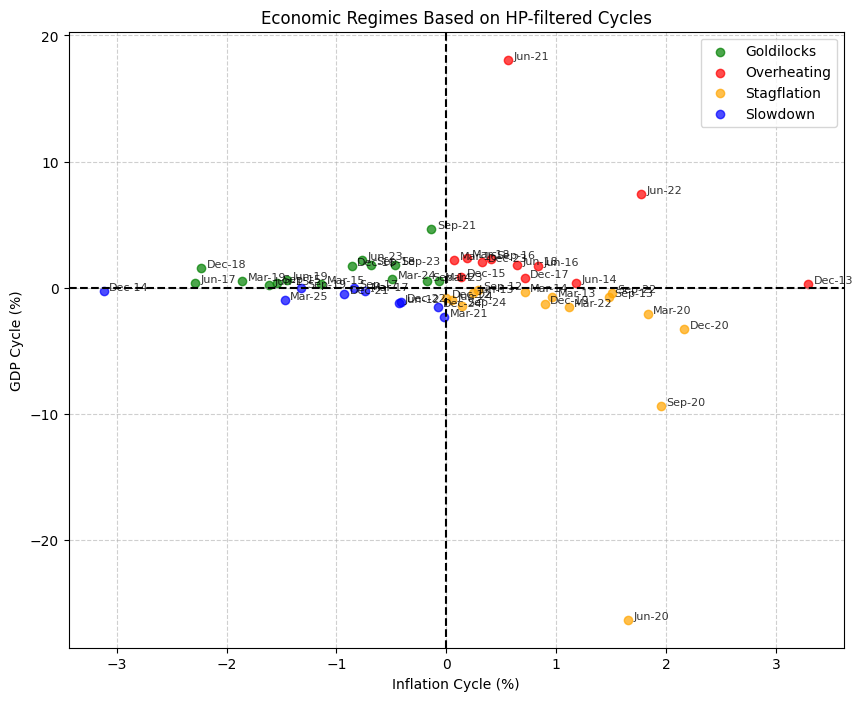

In [ ]:
plt.figure(figsize=(10,8))

# Plot each regime with color and label dates
for regime, color in zip(["Goldilocks","Overheating","Stagflation","Slowdown"],
                         ["green","red","orange","blue"]):
    subset = df[df["Regime_hp"] == regime]
    plt.scatter(subset["infl_cycle"], subset["gdp_cycle"], label=regime, alpha=0.7, c=color)

    # Add date labels
    for _, row in subset.iterrows():
        plt.text(row['infl_cycle'] + 0.05,  # small x-offset
                 row['gdp_cycle'] + 0.05,  # small y-offset
                 row['Dates'],             # original date string
                 fontsize=8,
                 alpha=0.8)

# Reference lines at 0 (trend)
plt.axhline(0, color="black", linestyle="--")  # GDP cycle = 0
plt.axvline(0, color="black", linestyle="--")  # Inflation cycle = 0

plt.xlabel("Inflation Cycle (%)")
plt.ylabel("GDP Cycle (%)")
plt.title("Economic Regimes Based on HP-filtered Cycles")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Zoomed in version of the scatter plot for readability

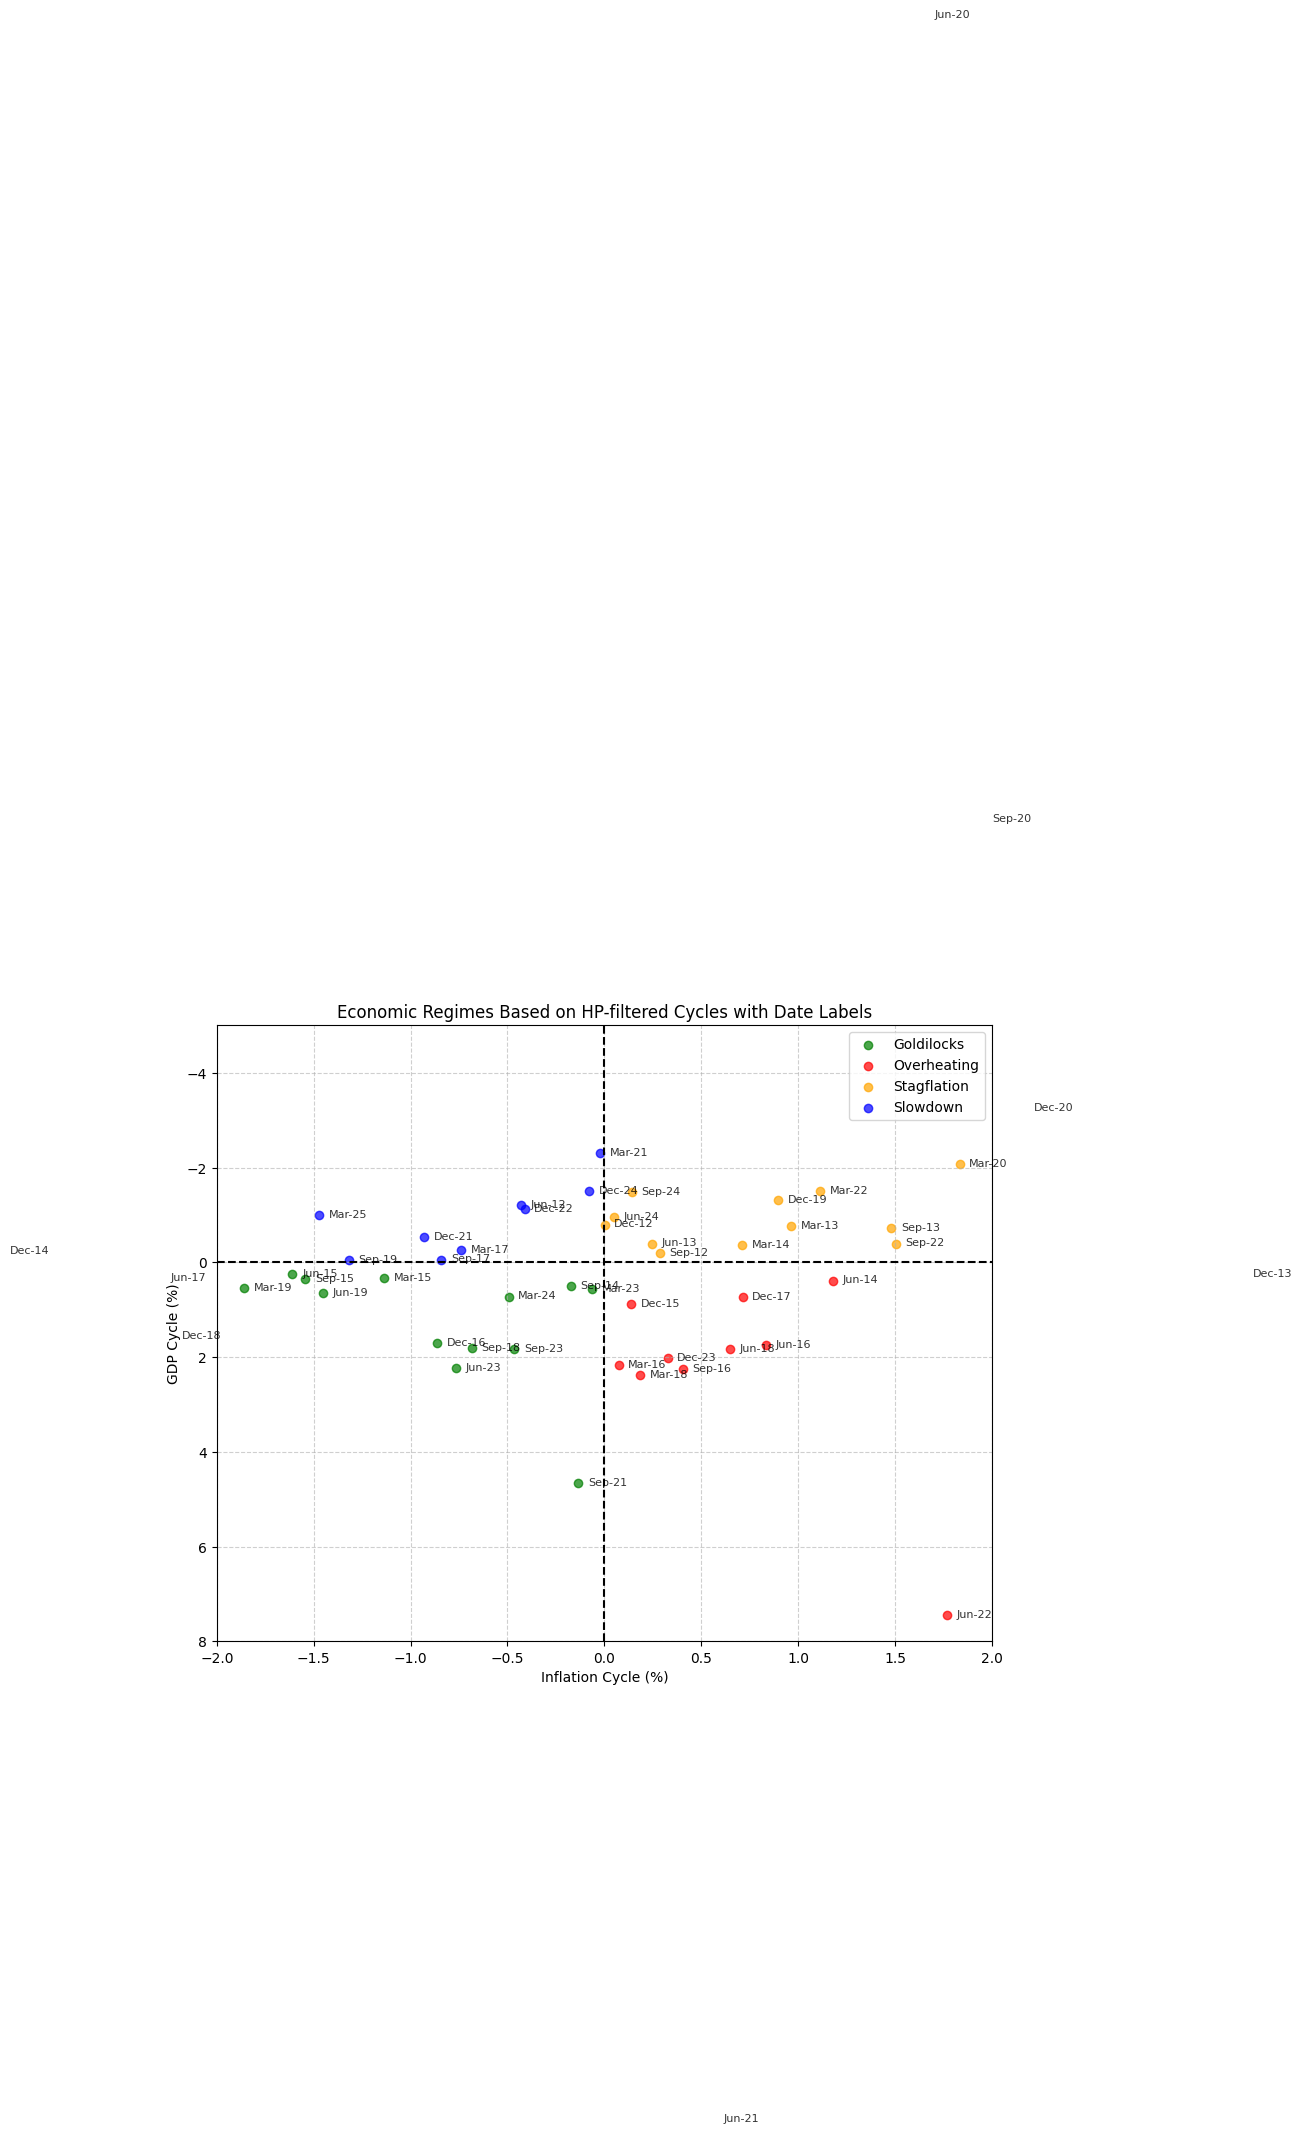

In [ ]:
plt.figure(figsize=(10,8))

# Plot each regime with color and label dates
for regime, color in zip(["Goldilocks","Overheating","Stagflation","Slowdown"],
                         ["green","red","orange","blue"]):
    subset = df[df["Regime_hp"] == regime]
    plt.scatter(subset["infl_cycle"], subset["gdp_cycle"], label=regime, alpha=0.7, c=color)

    # Add date labels
    for _, row in subset.iterrows():
        plt.text(row['infl_cycle'] + 0.05,  # small x-offset
                 row['gdp_cycle'] + 0.05,  # small y-offset
                 row['Dates'],             # original date string
                 fontsize=8,
                 alpha=0.8)

# Reference lines at 0 (trend)
plt.axhline(0, color="black", linestyle="--")  # GDP cycle = 0
plt.axvline(0, color="black", linestyle="--")  # Inflation cycle = 0
plt.xlim(-2, 2)
plt.ylim(8, -5)
plt.xlabel("Inflation Cycle (%)")
plt.ylabel("GDP Cycle (%)")
plt.title("Economic Regimes Based on HP-filtered Cycles with Date Labels")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

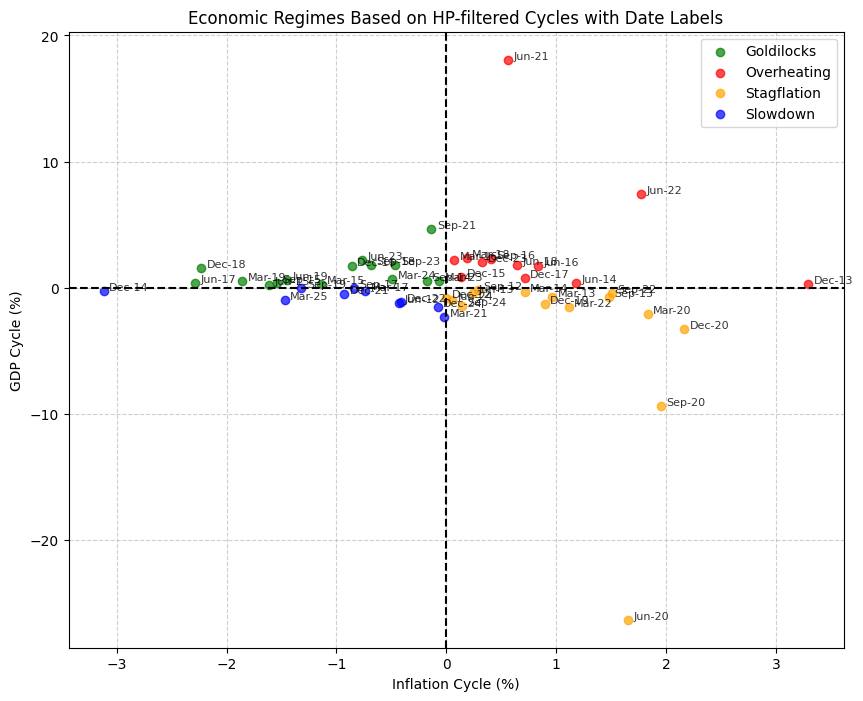

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

for regime, color in zip(["Goldilocks","Overheating","Stagflation","Slowdown"],
                         ["green","red","orange","blue"]):
    subset = df[df["Regime_hp"] == regime]
    plt.scatter(subset["infl_cycle"], subset["gdp_cycle"], label=regime, alpha=0.7, c=color)

    # Add date labels for each point
    for _, row in subset.iterrows():
        plt.text(row['infl_cycle'] + 0.05, row['gdp_cycle'] + 0.05,
                 row['Dates'], fontsize=8, alpha=0.8)

plt.axhline(0, color="black", linestyle="--")  # GDP cycle = 0
plt.axvline(0, color="black", linestyle="--")  # Inflation cycle = 0

plt.xlabel("Inflation Cycle (%)")
plt.ylabel("GDP Cycle (%)")
plt.title("Economic Regimes Based on HP-filtered Cycles with Date Labels")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

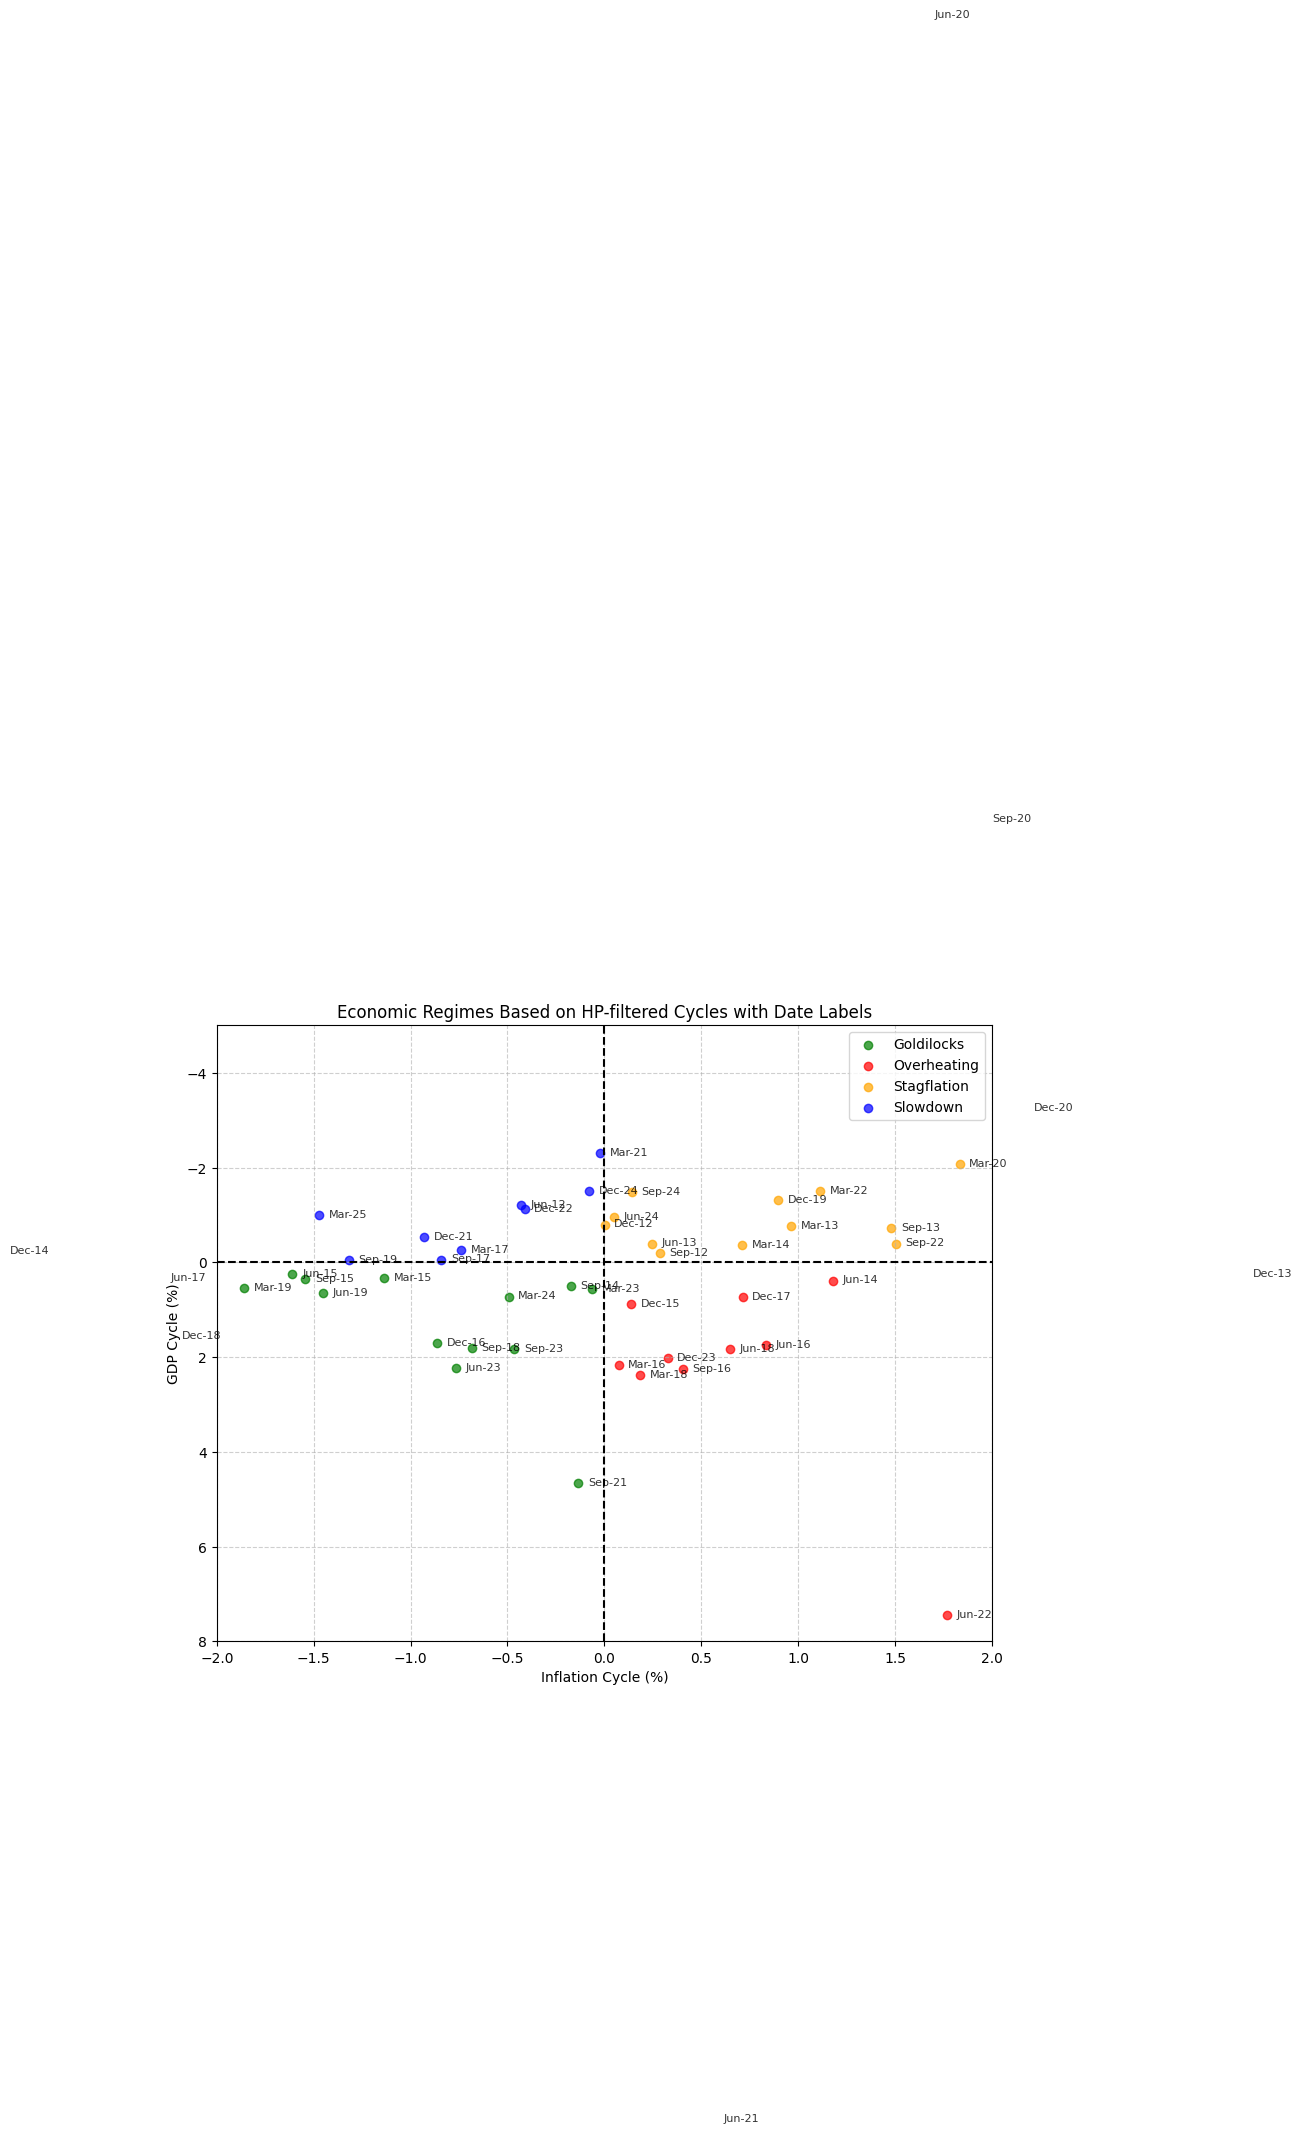

In [ ]:



plt.figure(figsize=(10,8))

for regime, color in zip(["Goldilocks","Overheating","Stagflation","Slowdown"],
                         ["green","red","orange","blue"]):
    subset = df[df["Regime_hp"] == regime]
    plt.scatter(subset["infl_cycle"], subset["gdp_cycle"], label=regime, alpha=0.7, c=color)

    # Add date labels for each point
    for _, row in subset.iterrows():
        plt.text(row['infl_cycle'] + 0.05, row['gdp_cycle'] + 0.05,
                 row['Dates'], fontsize=8, alpha=0.8)

plt.axhline(0, color="black", linestyle="--")  # GDP cycle = 0
plt.axvline(0, color="black", linestyle="--")  # Inflation cycle = 0
plt.xlim(-2, 2)
plt.ylim(8, -5)

plt.xlabel("Inflation Cycle (%)")
plt.ylabel("GDP Cycle (%)")
plt.title("Economic Regimes Based on HP-filtered Cycles with Date Labels")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()